In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import replace

import sympy as sp
import numpy as np
from numpy.testing import assert_allclose

from pystencils.session import *
from pystencils import Target
from lbmpy.session import *

from lbmpy.stencils import get_stencil

from lbmpy.methods.centeredcumulant import CenteredCumulantForceModel

from lbmpy.macroscopic_value_kernels import macroscopic_values_getter, macroscopic_values_setter

In [3]:
try:
    import pycuda
    import pycuda.gpuarray as gpuarray
except ImportError:
    pycuda = None
    target = ps.Target.CPU
    print('No pycuda installed')

if pycuda:
    target = ps.Target.GPU

## Pipe Flow Scenario

In [4]:
class PeriodicPipeFlow:
    def __init__(self, lbm_config, lbm_optimisation, config):

        wall_boundary = NoSlip()

        self.stencil = lbm_config.stencil
        self.streaming_pattern = lbm_config.streaming_pattern
        self.target = config.target

        self.gpu = self.target == Target.GPU

        #   Stencil
        self.q = stencil.Q
        self.dim = stencil.D

        #   Streaming
        self.inplace = is_inplace(self.streaming_pattern)
        self.timesteps = get_timesteps(self.streaming_pattern)
        self.zeroth_timestep = self.timesteps[0]

        #   Domain, Data Handling and PDF fields
        self.pipe_length = 60
        self.pipe_radius = 15
        self.domain_size = (self.pipe_length, ) + (2 * self.pipe_radius,) * (self.dim - 1)
        self.periodicity = (True, ) + (False, ) * (self.dim - 1)
        force = (0.0001, ) + (0.0,) * (self.dim - 1)
        self.force = lbm_config.force

        self.dh = create_data_handling(domain_size=self.domain_size,
                                       periodicity=self.periodicity, default_target=self.target)

        self.pdfs = self.dh.add_array('pdfs', self.q)
        if not self.inplace:
            self.pdfs_tmp = self.dh.add_array_like('pdfs_tmp', self.pdfs.name)

        lbm_optimisation = replace(lbm_optimisation, symbolic_field=self.pdfs)

        if not self.inplace:
            lbm_optimisation = replace(lbm_optimisation, symbolic_temporary_field=self.pdfs_tmp)

        self.lb_collision = create_lb_collision_rule(lbm_config=lbm_config, lbm_optimisation=lbm_optimisation)
        self.lb_method = self.lb_collision.method

        self.lb_kernels = []
        for t in self.timesteps:
            lbm_config = replace(lbm_config, timestep=t, collision_rule=self.lb_collision)
            self.lb_kernels.append(create_lb_function(lbm_config=lbm_config,
                                                      lbm_optimisation=lbm_optimisation,
                                                      config=config))

        #   Macroscopic Values
        self.density = 1.0
        self.density_field = self.dh.add_array('rho', 1)
        u_x = 0.0
        self.velocity = (u_x,) * self.dim
        self.velocity_field = self.dh.add_array('u', self.dim)

        single_gl_config = replace(config, ghost_layers=1)
        setter = macroscopic_values_setter(
            self.lb_method, self.density, self.velocity, self.pdfs,
            streaming_pattern=self.streaming_pattern, previous_timestep=self.zeroth_timestep)
        self.init_kernel = create_kernel(setter, config=single_gl_config).compile()

        self.getter_kernels = []
        for t in self.timesteps:
            getter = macroscopic_values_getter(
                self.lb_method, self.density_field, self.velocity_field, self.pdfs,
                streaming_pattern=self.streaming_pattern, previous_timestep=t)
            self.getter_kernels.append(create_kernel(getter, config=single_gl_config).compile())

        #   Periodicity
        self.periodicity_handler = LBMPeriodicityHandling(
            self.stencil, self.dh, self.pdfs.name, streaming_pattern=self.streaming_pattern)

        #   Boundary Handling
        self.wall = wall_boundary
        self.bh = LatticeBoltzmannBoundaryHandling(
            self.lb_method, self.dh, self.pdfs.name,
            streaming_pattern=self.streaming_pattern, target=self.target)

        self.bh.set_boundary(boundary_obj=self.wall, mask_callback=self.mask_callback)

        self.current_timestep = self.zeroth_timestep

    def mask_callback(self, x, y, z=None):
        y = y - self.pipe_radius
        z = z - self.pipe_radius if z is not None else 0
        return np.sqrt(y**2 + z**2) >= self.pipe_radius

    def init(self):
        self.current_timestep = self.zeroth_timestep
        self.dh.run_kernel(self.init_kernel)

    def step(self):
        #   Order matters! First communicate, then boundaries, otherwise
        #   periodicity handling overwrites reflected populations
        # Periodicty
        self.periodicity_handler(self.current_timestep)

        # Boundaries
        self.bh(prev_timestep=self.current_timestep)

        # Here, the next time step begins
        self.current_timestep = self.current_timestep.next()

        # LBM Step
        self.dh.run_kernel(self.lb_kernels[self.current_timestep.idx])

        # Field Swaps
        if not self.inplace:
            self.dh.swap(self.pdfs.name, self.pdfs_tmp.name)

        # Macroscopic Values
        self.dh.run_kernel(self.getter_kernels[self.current_timestep.idx])

    def run(self, iterations):
        for _ in range(iterations):
            self.step()

    @property
    def velocity_array(self):
        if self.gpu:
            self.dh.to_cpu(self.velocity_field.name)
        return self.dh.gather_array(self.velocity_field.name)

    def get_trimmed_velocity_array(self):
        if self.gpu:
            self.dh.to_cpu(self.velocity_field.name)
        u = np.copy(self.dh.gather_array(self.velocity_field.name))
        mask = self.bh.get_mask(None, self.wall)
        for idx in np.ndindex(u.shape[:-1]):
            if mask[idx] != 0:
                u[idx] = np.full((self.dim, ), np.nan)
        return u


## General Setup

In [5]:
stencil = LBStencil(Stencil.D3Q19)
dim = stencil.D
streaming_pattern = 'aa'

config = ps.CreateKernelConfig(target=target)

viscous_rr = 1.1
force = (0.0001, ) + (0.0,) * (dim - 1)

## 1. Reference: SRT Method

In [6]:
srt_config = LBMConfig(stencil=stencil, method=Method.SRT, relaxation_rate=viscous_rr,
                       force_model=ForceModel.SIMPLE, force=force, streaming_pattern=streaming_pattern)

srt_flow = PeriodicPipeFlow(srt_config, LBMOptimisation(), config)
srt_flow.init()
srt_flow.run(400)

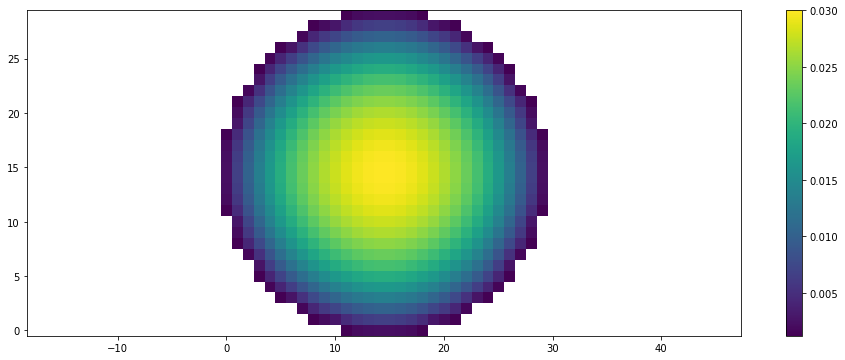

In [7]:
srt_u = srt_flow.get_trimmed_velocity_array()
ps.plot.vector_field_magnitude(srt_u[30,:,:,:])
ps.plot.colorbar()

## 2. Centered Cumulant Method with Implicit Forcing

The default setup of the centered cumulant method does not use a force model to compute the force contributions on all populations, but instead applies the force in cumulant space simply by setting the momentum relaxation rate $\omega_1 = 2$. Due to the half-force shift of the equilibrium input velocity, the first central moments (which correspond to momentum relative to the moving frame of reference) are not zero, but equal to $-F/2$. The relaxation process causes the first central moments to simply change sign:
$$
    \kappa_{100}^* = - \kappa_{100}.
$$
Thus, $\kappa_{100}^* = F_x /2$. In total, the entire acceleration given by the force is added onto the momentum.

In [8]:
cm_config = LBMConfig(method=Method.MONOMIAL_CUMULANT, stencil=stencil, compressible=True,
                      relaxation_rate=viscous_rr, force_model=CenteredCumulantForceModel(force),
                      force=force, streaming_pattern=streaming_pattern)

lbm_opt = LBMOptimisation(pre_simplification=True)

cm_impl_f_flow = PeriodicPipeFlow(cm_config, lbm_opt, config)

In [9]:
lb_method = cm_impl_f_flow.lb_method
assert all(rr == 2 for rr in lb_method.relaxation_rates[1:4])
assert all(rr == viscous_rr for rr in lb_method.relaxation_rates[4:9])

In [10]:
cm_impl_f_flow.init()
cm_impl_f_flow.run(400)

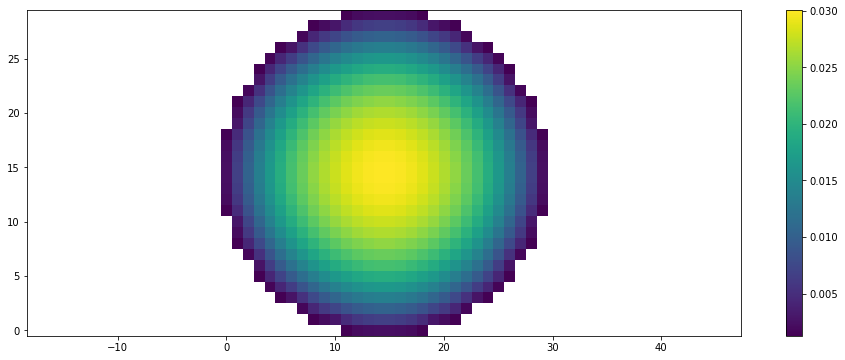

In [11]:
cm_impl_f_u = cm_impl_f_flow.get_trimmed_velocity_array()
ps.plot.vector_field_magnitude(cm_impl_f_u[30,:,:,:])
ps.plot.colorbar()

In [12]:
assert_allclose(cm_impl_f_u, srt_u, rtol=1, atol=1e-4)

## 3. Centered Cumulant Method with Explicit Forcing

In [13]:
from lbmpy.forcemodels import Simple

cm_expl_force_config = LBMConfig(method=Method.CUMULANT, stencil=stencil, compressible=True,
                      relaxation_rate=viscous_rr, force_model=Simple(force),
                      force=force, streaming_pattern=streaming_pattern)

lbm_opt = LBMOptimisation(pre_simplification=True)

cm_expl_f_flow = PeriodicPipeFlow(cm_expl_force_config, lbm_opt, config)

In [14]:
lb_method = cm_expl_f_flow.lb_method
assert all(rr == 0 for rr in lb_method.relaxation_rates[1:4])
assert all(rr == viscous_rr for rr in lb_method.relaxation_rates[4:9])

In [15]:
cm_expl_f_flow.init()
cm_expl_f_flow.run(400)

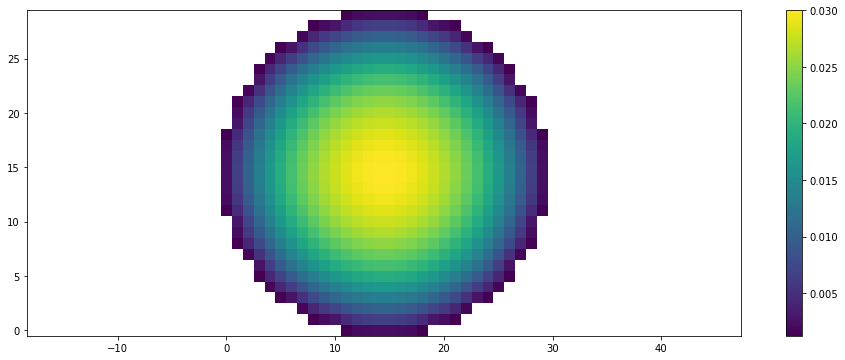

In [16]:
cm_expl_f_u = cm_expl_f_flow.get_trimmed_velocity_array()
ps.plot.vector_field_magnitude(cm_expl_f_u[30,:,:,:])
ps.plot.colorbar()

In [17]:
assert_allclose(cm_expl_f_u, srt_u, rtol=1, atol=1e-4)
assert_allclose(cm_expl_f_u, cm_impl_f_u, rtol=1, atol=1e-4)